In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import pyfolio as pf
from datetime import datetime

In [14]:
data_path = r"data.csv"

#  Strategy 1

invest 1 dollar whenever machine learning predicts a win

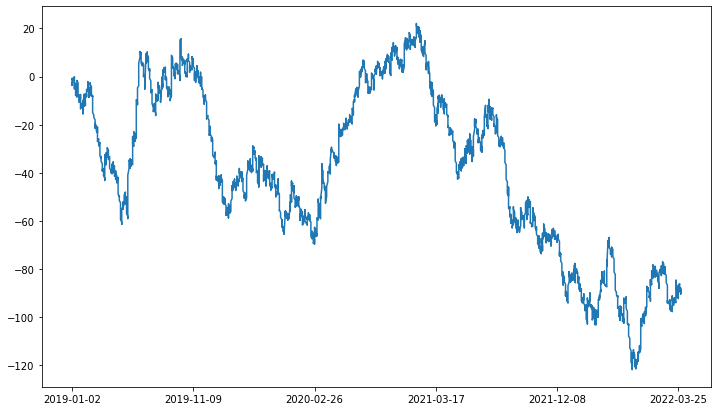

In [15]:
f = pd.read_csv(data_path)
# Invest 1 dolloar whever wonprob is greater than 0.5
f.loc[:, "home_bet_total"] = f.loc[:, "home_predict_winprob"].apply(lambda x: 1 if (x>0.5) else 0)
f.loc[:, "away_bet_total"] = f.loc[:, "away_predict_winprob"].apply(lambda x: 1 if (x>0.5) else 0)


# Create booleans for if home team loses
f.loc[:, "home_lose"] = abs(f.loc[:, "home_win"] - 1)

# Calculate how much portion of money gained when win or lose
# when betted team win, we gain money according to moneyline as shown below:
f.loc[:, "home_win_gain"] = f.loc[:, "money_line_home"].apply(lambda x: x/100 if x >=0 else 100/abs(x) )
f.loc[:, "away_win_gain"] = f.loc[:, "money_line_away"].apply(lambda x: x/100 if x >=0 else 100/abs(x) )

# when betted team lose, we lose all money
f.loc[:, "home_lose_gain"] = -1
f.loc[:, "away_lose_gain"] = -1

# calculate earning
f.loc[:, "home_bet_earning"] = f.loc[:, "home_win"] * f.loc[:, "home_win_gain"] * f.loc[:, "home_bet_total"]
f.loc[:, "home_bet_earning"] += f.loc[:, "home_lose"] * f.loc[:, "home_lose_gain"] * f.loc[:, "home_bet_total"]

f.loc[:, "away_bet_earning"] = f.loc[:, "home_lose"] * f.loc[:, "away_win_gain"] * f.loc[:, "away_bet_total"]
f.loc[:, "away_bet_earning"] += f.loc[:, "home_win"] * f.loc[:, "away_lose_gain"] * f.loc[:, "away_bet_total"]

f.loc[:, "bet_earning_sum"] = f.loc[:, "home_bet_earning"]  + f.loc[:, "away_bet_earning"]

# calculate acculated sum
f.loc[:, "bet_earning_cum_sum"] = f.loc[:, "bet_earning_sum"].cumsum()

# plot accumulated sum
import numpy as np
xticks = np.arange(0, len(f), 100)
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.set_xticks(xticks)
ax.plot(f.datetime, f.bet_earning_cum_sum)

#print("average investment per game= {}".format(np.mean(f.loc[:, "home_bet_total"].mean())))

用pyfolio计算回测指标.

因为pyfolio的要求, 这里假设每次下注为一天. 总资金投入100刀.

In [16]:
from datetime import timedelta
f.loc[:, "random_date"] = pd.date_range(end = datetime(2022,3,31), periods = len(f))
pf.create_full_tear_sheet(returns=(f.set_index("random_date").loc[:, "bet_earning_cum_sum"]+100).pct_change())

c:\Users\user\anaconda3\envs\nba_bet_machine_learning\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
c:\Users\user\anaconda3\envs\nba_bet_machine_learning\lib\site-packages\empyrical\stats.py:1494: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


Start date,2012-09-27
End date,2022-03-31
Total months,165
,Backtest
Annual return,-14.2%
Cumulative returns,-87.9%
Annual volatility,3925.8%
Sharpe ratio,0.27
Calmar ratio,-0.12
Stability,NaN
Max drawdown,-118.0%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

#  Strategy 2

invest 1 dollar multipled by kelly criteria

In [17]:
def calc_winprob(odds):
    if odds >= 0:
        return round(100/(odds+100), 2)
    else:
        return round(1 - 100/(-odds+100), 2)

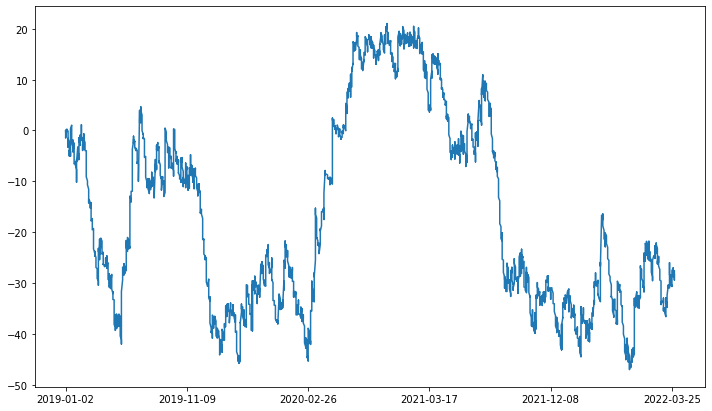

In [18]:
f = pd.read_csv(data_path)
# caculate how much money to bet according to kelly criteria
f.loc[:, "actual_home_winprob"] = f.loc[:, "money_line_home"].apply(calc_winprob)
f.loc[:, "actual_away_winprob"] = f.loc[:, "money_line_away"].apply(calc_winprob)
f.loc[:, "kelly_home"] = (((1 - f.loc[:, "actual_home_winprob"]) / f.loc[:, "actual_home_winprob"]) * f.loc[:, "home_predict_winprob"] - (1 - f.loc[:, "home_predict_winprob"])) / (
                    (1 - f.loc[:, "actual_home_winprob"]) / f.loc[:, "actual_home_winprob"])

f.loc[:, "kelly_away"] = (((1 - f.loc[:, "actual_away_winprob"]) / f.loc[:, "actual_away_winprob"]) * f.loc[:, "away_predict_winprob"] - (1 - f.loc[:, "away_predict_winprob"])) / (
                    (1 - f.loc[:, "actual_away_winprob"]) / f.loc[:, "actual_away_winprob"])

f.loc[:, "kelly_home"] = f.loc[:, "kelly_home"].apply(lambda x: x if x > 0.0 else 0)
f.loc[:, "kelly_away"] = f.loc[:, "kelly_away"].apply(lambda x: x if x > 0.0 else 0)

# Invest 1 multipled by kelly calculated result
f.loc[:, "home_bet_total"] = f.loc[:, "kelly_home"]
f.loc[:, "away_bet_total"] = f.loc[:, "kelly_away"]



# Create booleans for if home team loses
f.loc[:, "home_lose"] = abs(f.loc[:, "home_win"] - 1)

# Calculate how much portion of money gained when win or lose
# when betted team win, we gain money according to moneyline as shown below:
f.loc[:, "home_win_gain"] = f.loc[:, "money_line_home"].apply(lambda x: x/100 if x >=0 else 100/abs(x) )
f.loc[:, "away_win_gain"] = f.loc[:, "money_line_away"].apply(lambda x: x/100 if x >=0 else 100/abs(x) )

# when betted team lose, we lose all money
f.loc[:, "home_lose_gain"] = -1
f.loc[:, "away_lose_gain"] = -1

# calculate earning
f.loc[:, "home_bet_earning"] = f.loc[:, "home_win"] * f.loc[:, "home_win_gain"] * f.loc[:, "home_bet_total"]
f.loc[:, "home_bet_earning"] += f.loc[:, "home_lose"] * f.loc[:, "home_lose_gain"] * f.loc[:, "home_bet_total"]

f.loc[:, "away_bet_earning"] = f.loc[:, "home_lose"] * f.loc[:, "away_win_gain"] * f.loc[:, "away_bet_total"]
f.loc[:, "away_bet_earning"] += f.loc[:, "home_win"] * f.loc[:, "away_lose_gain"] * f.loc[:, "away_bet_total"]

f.loc[:, "bet_earning_sum"] = f.loc[:, "home_bet_earning"]  + f.loc[:, "away_bet_earning"]

# calculate acculated sum
f.loc[:, "bet_earning_cum_sum"] = f.loc[:, "bet_earning_sum"].cumsum()

# plot accumulated sum
import numpy as np
xticks = np.arange(0, len(f), 100)
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.set_xticks(xticks)
ax.plot(f.datetime, f.bet_earning_cum_sum)


#print("average investment per game= {}".format(np.mean(f.loc[:, "home_bet_total"].mean())))

In [19]:
def max_drawdown(df):
    md=((df.loc[:, "bet_earning_sum"].cummax()-f.loc[:, "bet_earning_sum"])/(df.loc[:, "bet_earning_sum"].cummax())).max()
    return round(md,4)

max_drawdown(f)

1.612

用pyfolio计算回测指标.

因为pyfolio的要求, 这里假设每次下注为一天. 总资金投入100刀.

In [20]:
from datetime import timedelta
f.loc[:, "random_date"] = pd.date_range(end = datetime(2022,3,31), periods = len(f))
pf.create_full_tear_sheet(returns=(f.set_index("random_date").loc[:, "bet_earning_cum_sum"]+100).pct_change())

c:\Users\user\anaconda3\envs\nba_bet_machine_learning\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2012-09-27
End date,2022-03-31
Total months,165
,Backtest
Annual return,-2.3%
Cumulative returns,-27.5%
Annual volatility,23.3%
Sharpe ratio,0.01
Calmar ratio,-0.04
Stability,0.04
Max drawdown,-56.2%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

##### 离谱.